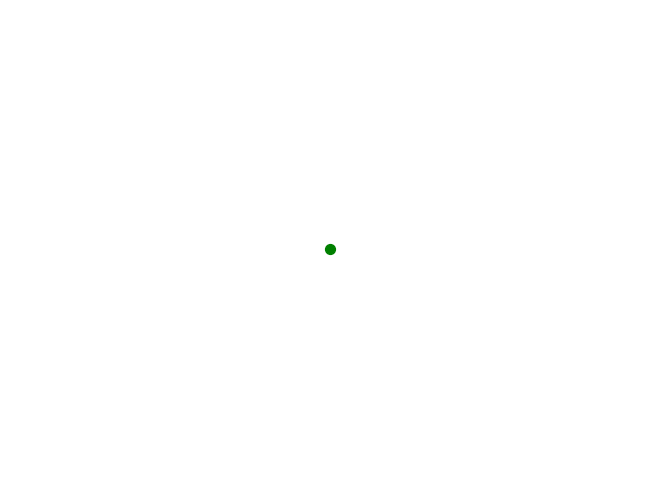

{('WSCentral', 2025): 0.232833684048, ('WSCentral', 2026): 0.23827262834399998, ('TRE', 2025): 0.239937988164, ('TRE', 2026): 0.23347262834399998, ('SPPS', 2025): 0.228033684048, ('SPPS', 2026): 0.23347262834399998, ('SAtlantic', 2025): 0.234524927052, ('SAtlantic', 2026): 0.23827262834399998, ('FRCC', 2025): 0.229724927052, ('FRCC', 2026): 0.23347262834399998, ('SRCA', 2025): 0.23347262834399998, ('SRCA', 2026): 0.23347262834399998, ('PJMD', 2025): 0.24068844891599997, ('PJMD', 2026): 0.23347262834399998, ('ESCentral', 2025): 0.229724927052, ('ESCentral', 2026): 0.23347262834399998, ('MISS', 2025): 0.24649452202799998, ('MISS', 2026): 0.228672628344, ('SRSE', 2025): 0.260573074164, ('SRSE', 2026): 0.228672628344, ('SRCE', 2025): 0.224924927052, ('SRCE', 2026): 0.228672628344, ('ENCentral', 2025): 0.234524927052, ('ENCentral', 2026): 0.23827262834399998, ('MISC', 2025): 0.24652786874399998, ('MISC', 2026): 0.23347262834399998, ('MISE', 2025): 0.229724927052, ('MISE', 2026): 0.233472628

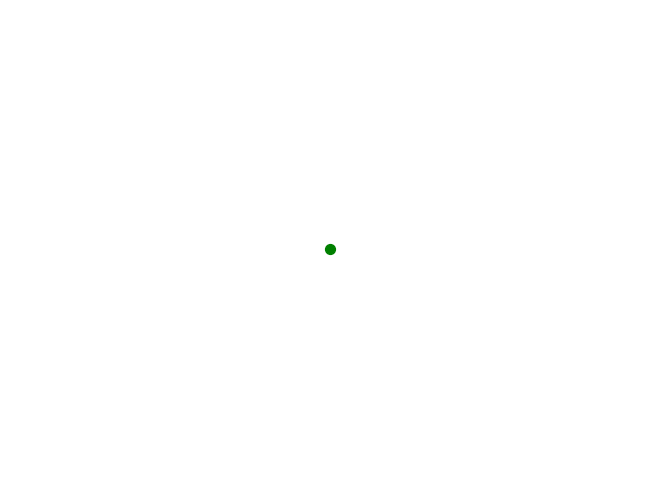

integrated
ERROR: Rule failed for Param 'little.cost' with index ('hub18', 'PEM', 2025):
KeyError: (7, 2025)
ERROR: Constructing component 'little' from data=None failed: KeyError: (7,
2025)


KeyError: (7, 2025)

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 11 09:28:58 2024

@author: JNI
"""

import pandas as pd
import random as rnd
import regions_integrated2 
from pyomo.environ import *

'''
THIS IS A SIMPLE SCRIPT THAT USES A MADE UP DEMAND AND PRICES

it imports the region class, generates a grid, creates a model object running
in 'integrated' mode with the price and demand as inputs, builds the model and
saves the return value as copied model
'''


# generate some price and demand data

def demand_curve(h2_price_data, iteration = 1):   
    h2_price_data['demand_' + str(iteration)] = (1 - h2_price_data['price'] /  (30*1.05**(h2_price_data['year']-2024)))*500000*1.2**(h2_price_data['year']-2024)
    return h2_price_data

# read a csv file for demand as a df and append prices to it
data_price = demand_curve(pd.read_csv('C:/Users/MLJ/Downloads/H2/regionality and hubs/h2_price.csv'))

#convert the df into dicts
price = {(region,year): data_price[(data_price['region'] == region) & (data_price['year'] == year)].iloc[0]['price']*.04 for region in data_price['region'].unique() for year in data_price['year'].unique()}
demand = {(region,year): data_price[(data_price['region'] == region) & (data_price['year'] == year)].iloc[0]['demand_1'] for region in data_price['region'].unique() for year in data_price['year'].unique()}

print(price)

#create a grid instance loading from data, and build it
grid = regions_integrated2.Grid(regions_integrated2.Data())
grid.build_grid()

# create a model instance that takes the grid as input, runs in integrated mode
# and takes demand and electricity_price as inputs. 
# 
model = regions_integrated2.Model(grid, mode = 'integrated', demand = demand, electricity_price = price)

# start_build builds a pyomo block and returns it as a value saved as copied_model
copied_model = model.start_build()

# big model is a concrete model, and we attach the block copied_model to it as little
bigmodel = ConcreteModel()
bigmodel.little = copied_model

# solve bigmodel and it solves little

solver = SolverFactory('appsi_highs')
solver.solve(bigmodel,tee=True).write()

In [2]:
####################################################################################################################
####################################################################################################################
#PRE-PROCESSING
####################################################################################################################
####################################################################################################################


#Import pacakges
from datetime import datetime
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import gc
import highspy
from pyomo.common.timing import TicTocTimer
import os


import sympy as sp
import statsmodels.api as sm

import regions_integrated2

#import scripts
import preprocessor_simple as prep
#import postprocessor as post

####################################################################################################################


In [3]:
   


############################################
# RUN NEWW ECM MODEL BY ITSELF
############################################
model3 = pyo.ConcreteModel(name='MultiBlock')
model3.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

test_years = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_year.csv').dropna()['year'])
test_regions = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_reg.csv').dropna()['region'])

all_frames, setin = prep.preprocessor(prep.Sets(test_years,test_regions),'C:/Users/MLJ/Downloads/ECM Simple/input/temp/')

model3.year = pyo.Set(initialize = setin.y)
model3.regions = pyo.Set(initialize = range(7,8))

model3.electricity_price = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
model3.demand = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
# params to pass into ECM
model3.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
model3.H2Price = pyo.Param(model3.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model

# create a model instance that takes the grid as input, runs in integrated mode
# and takes demand and electricity_price as inputs. 
# 
model = regions_integrated2.Model(grid, mode = 'integrated', demand = model3.demand, electricity_price = model3.electricity_price)


# start_build builds a pyomo block and returns it as a value saved as copied_model

copied_model = model.start_build()

# big model is a concrete model, and we attach the block copied_model to it as little
bigmodel = ConcreteModel()
bigmodel.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
bigmodel.little = copied_model

def total_profit_rule(model3):
    return bigmodel.little.production_cost
model3.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)
#model3.little = copied_model

# solve bigmodel and it solves little

solver = SolverFactory('appsi_highs')
solver.solve(bigmodel,tee=True).write()

# PULL DUAL VALUES TO CALCULATE ELECTRICITY PRICE TO PASS TO ECM
for c in bigmodel.component_objects(pyo.Constraint, active=True):
    const = str(c)
    if const=="little.demand_constraint":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(bigmodel.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

### ELEC PRICE MUST BE INDEXED BY REG AND YEAR ONLY
# ASSIGN SUPPLY PRICE VECTOR AS DUAL VARIABLES
for (reg, s, pt, step, y) in model3.H2PriceSet:
    if pt==5:
        r = int(reg)
        steps= int(step)
        yr = int(y)
        s2 = int(s)
        #r	s	pt	steps	y
        model3.H2Price[r, s2, 5, step, yr].value = -bigmodel.dual[bigmodel.little.demand_constraint[r, yr]]


integrated
integrated
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from
c:\Users\MLJ\Downloads\H2\regionality and hubs\regions_integrated2.py:988)
Presolving model
0 rows, 0 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-4); columns 0(-4); elements 0(-5) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  0.0000000000e+00
HiGHS run time      :          0.00
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: 

In [ ]:
model.regions.pprint()